In this code, we look at a damped nonlinear pendulum. We then try and use the PINN to find the values for $\omega_0$ and $\beta$


$$
\frac{d^2 x}{dt^2} = -\omega_0^2 \sin(x) - \beta \frac{dx}{dt}
$$

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as ticker
from scipy.special import ellipk
torch.manual_seed(125)

In [3]:
def sin(x):
    if isinstance(x, torch.Tensor):
        return torch.sin(x)
    else:
        return np.sin(x)
    
from pathlib import Path
# Create used directories
directories = ["plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")

Directory 'plots' is present. ✅


## Generate training data

In [60]:
# Initial conditions, Domain, and parameters

ti, tf = 0, 3
N  = 10_000
t = torch.linspace(ti, tf, N).view(-1,1)

# Initial Conditions
X0 = [1, 0]

# Natural Frequency of nonlinear Pendulum
w0 = 2*np.pi*1

# Damping Coefficient
b = 1

# True Period of nonlinear Pendulum
NP_Period  = 4/w0 * ellipk(np.sin(X0[0]/2)**2)

In [61]:
print(f'NP  Period: {NP_Period:.4f}')

NP  Period: 1.0663


In [62]:
# Numerical Solution

def ODE(X, t):
    dXdt = [X[1], -(w0**2)*np.sin(X[0]) - b*X[1]]
    return dXdt


# Nonlinear Pendulum Solution
solution = torch.from_numpy(odeint(ODE, X0, t.numpy().flatten())).view(-1,2)
x1       = solution[:,0]
x2       = solution[:,1]
x1_max   = torch.abs(x1).max().item()
x2_max   = torch.abs(x2).max().item()

# solution.dtype = np.double

# Pick points for training
N_training = 20
t_data     = torch.linspace(ti, 0.4*tf, N_training).view(-1,1)
training_data = solution[torch.searchsorted(t.flatten(), t_data.flatten()), :]
x1_data       = training_data[:,0].view(-1,1)
x2_data       = training_data[:,1].view(-1,1)

# Pick a few points for validation
N_validation = 100
t_val        = torch.linspace(ti*1.1, tf, N_validation).view(-1,1)
validation_data = solution[torch.searchsorted(t.flatten(), t_val.flatten()), :]
x1_val          = validation_data[:,0].view(-1,1)
x2_val          = validation_data[:,1].view(-1,1)

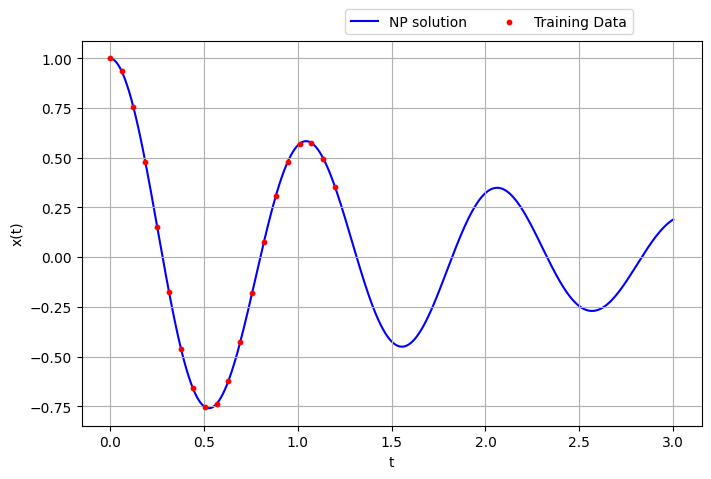

In [63]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t, x1, label='NP solution', color='blue', zorder=1)
ax.scatter(t_data, x1_data, color='red', label='Training Data', s=10, zorder=3)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
plt.legend(ncol=3, bbox_to_anchor=(0.9, 1.1))
plt.grid()
plt.show()

## PINN

In [64]:
def plot_result():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    axes[0].grid()
    axes[0].plot(t, x1, color="black", linewidth=2, alpha=1,linestyle='--',label="Nonlinear Pendulum", zorder=0)
    axes[0].plot(t, p, color="blue", linewidth=2, alpha=0.8, label="PINN prediction", zorder=1)
    axes[0].scatter(t_data, x1_data, s=15, color="red", alpha=0.4, label='Training data', zorder=2)
    axes[0].scatter(t_physics.detach(), -0*torch.ones_like(t_physics.detach()), s=10, color="green", alpha=0.4,label='Collocation points', zorder=2)
    axes[0].set_ylim(-1.05*x1_max, 1.05*x1_max)
    axes[0].set_ylabel('x(t)',fontsize="x-large")
    axes[0].set_xlabel('t',fontsize="x-large")
    axes[0].legend()
    
    axes[1].grid()
    axes[1].plot(training_loss_history, label='Training Loss', color='red', linewidth=2, zorder=1)
    # axes[1].plot(validation_loss_history, label='Validation Loss', color='blue', linewidth=1.5, zorder=2, alpha=0.6)
    axes[1].plot(error_history, label='MSE', color='green', linewidth=2, zorder=3, alpha=0.5)
    axes[1].set_yscale('log')
    axes[1].set_xlim(0, epochs)
    axes[1].set_ylim(1e-7, 1e2)
    axes[1].set_xlabel('Epochs', fontsize="x-large")
    axes[1].set_ylabel('Loss', fontsize="x-large")
    axes[1].set_title(f'MSE = {error:.3e}', fontsize="x-large")
    axes[1].legend()
    
    fig.suptitle(f"Epoch {i}", fontsize="x-large")

    plt.tight_layout()
    plt.axis("on")

In [65]:
# Define Neural Network Structure

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.scale = lambda t: (t - ti)/(tf - ti)
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.scale(x)
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [66]:
learning_rate = 1e-2
gamma         = 0.85
patience      = 500
epochs        = 20_000 + 1
weights = [w_data, w_derivative, w_ode] = [1e4, 0e1, 1e1]

N_phys   = 50
N_layers = 3
N_nodes  = 64

def error(y, x):
    return torch.mean((y - x)**2)/torch.mean(x**2)

In [67]:
# Define the samle locations for training data
t_training  = t_data.clone().requires_grad_(True)

# Define the sample locations for validation
t_validation = t_val.clone().requires_grad_(True)

# Define the sample locations for physics-informed training
t_physics = torch.linspace(ti, tf, N_phys).view(-1,1).requires_grad_(True)


Epoch 0: Error = 1.6673e-01, Omega = 0.990, NP Omega = 6.283, beta = -0.010, NP Beta = 1.000, Learning rate = 1.0000e-02


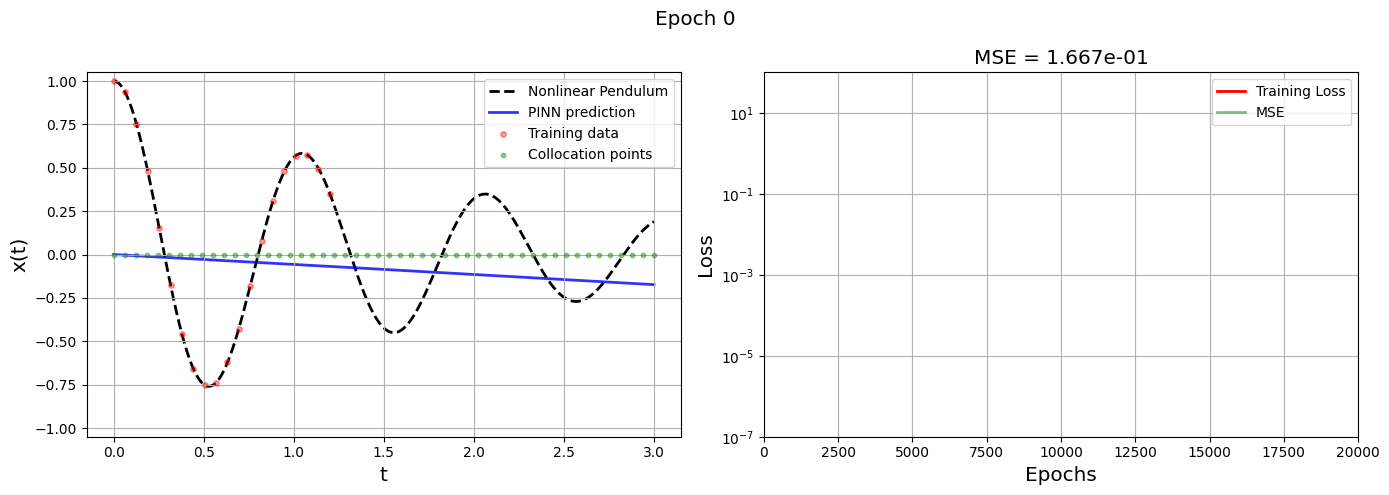

Epoch 100: Error = 1.6030e-01, Omega = 0.849, NP Omega = 6.283, beta = -0.034, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 200: Error = 1.4659e-01, Omega = 1.022, NP Omega = 6.283, beta = 0.272, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 300: Error = 1.2823e-01, Omega = 3.309, NP Omega = 6.283, beta = 1.307, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 400: Error = 6.0173e-02, Omega = 4.604, NP Omega = 6.283, beta = 1.618, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 500: Error = 5.1689e-02, Omega = 5.444, NP Omega = 6.283, beta = 1.576, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 600: Error = 3.4752e-02, Omega = 5.715, NP Omega = 6.283, beta = 1.561, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 700: Error = 3.1211e-02, Omega = 5.746, NP Omega = 6.283, beta = 1.553, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 800: Error = 2.7515e-02, Omega = 5.902, NP Omega = 6.283, beta = 1.507, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 900: Error = 1.98

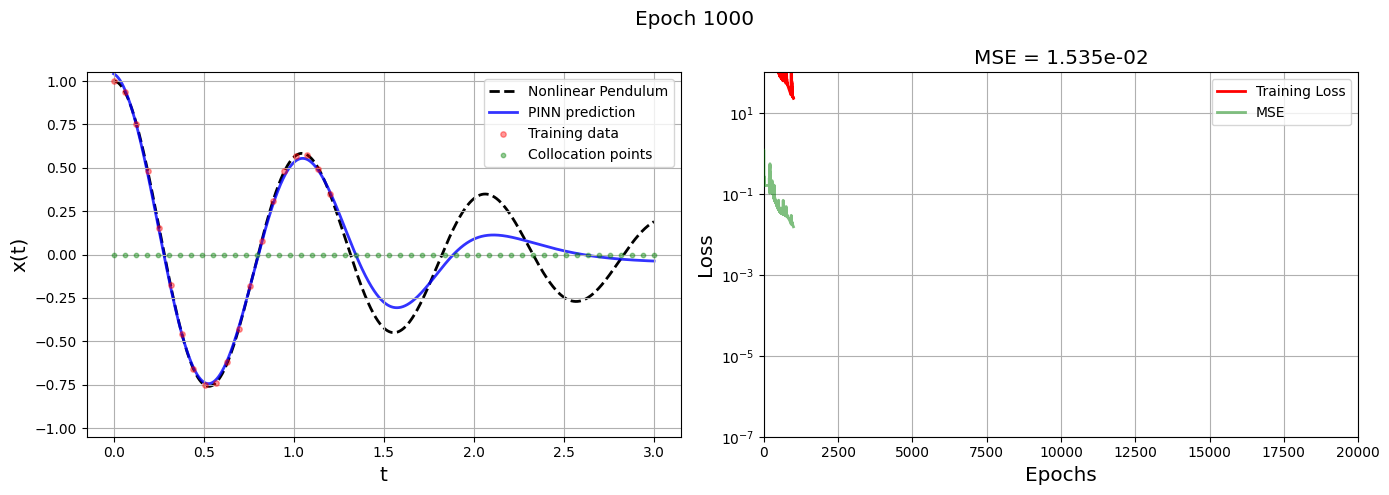

Epoch 1100: Error = 1.4061e-02, Omega = 6.116, NP Omega = 6.283, beta = 1.333, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1200: Error = 1.0464e-02, Omega = 6.199, NP Omega = 6.283, beta = 1.324, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1300: Error = 1.0779e-02, Omega = 6.177, NP Omega = 6.283, beta = 1.319, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1400: Error = 1.0112e-02, Omega = 6.195, NP Omega = 6.283, beta = 1.322, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1500: Error = 8.1199e-03, Omega = 6.221, NP Omega = 6.283, beta = 1.303, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1600: Error = 7.5778e-03, Omega = 6.217, NP Omega = 6.283, beta = 1.293, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1700: Error = 5.9635e-03, Omega = 6.221, NP Omega = 6.283, beta = 1.265, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1800: Error = 5.5439e-03, Omega = 6.223, NP Omega = 6.283, beta = 1.258, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 1900: Erro

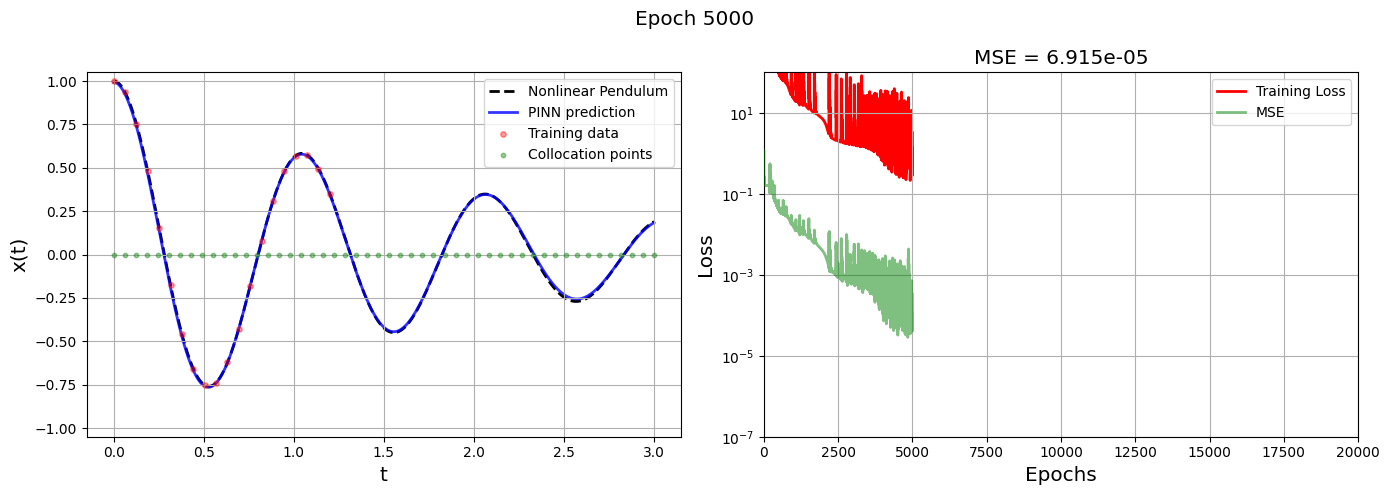

Epoch 5100: Error = 1.8541e-03, Omega = 6.236, NP Omega = 6.283, beta = 1.012, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5200: Error = 8.6373e-04, Omega = 6.254, NP Omega = 6.283, beta = 1.021, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5300: Error = 5.1222e-04, Omega = 6.266, NP Omega = 6.283, beta = 1.015, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5400: Error = 4.2911e-05, Omega = 6.275, NP Omega = 6.283, beta = 1.017, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5500: Error = 4.4025e-05, Omega = 6.270, NP Omega = 6.283, beta = 1.014, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5600: Error = 3.8173e-04, Omega = 6.272, NP Omega = 6.283, beta = 1.014, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5700: Error = 1.0044e-04, Omega = 6.278, NP Omega = 6.283, beta = 1.018, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5800: Error = 3.4416e-04, Omega = 6.268, NP Omega = 6.283, beta = 1.017, NP Beta = 1.000, Learning rate = 1.0000e-02
Epoch 5900: Erro

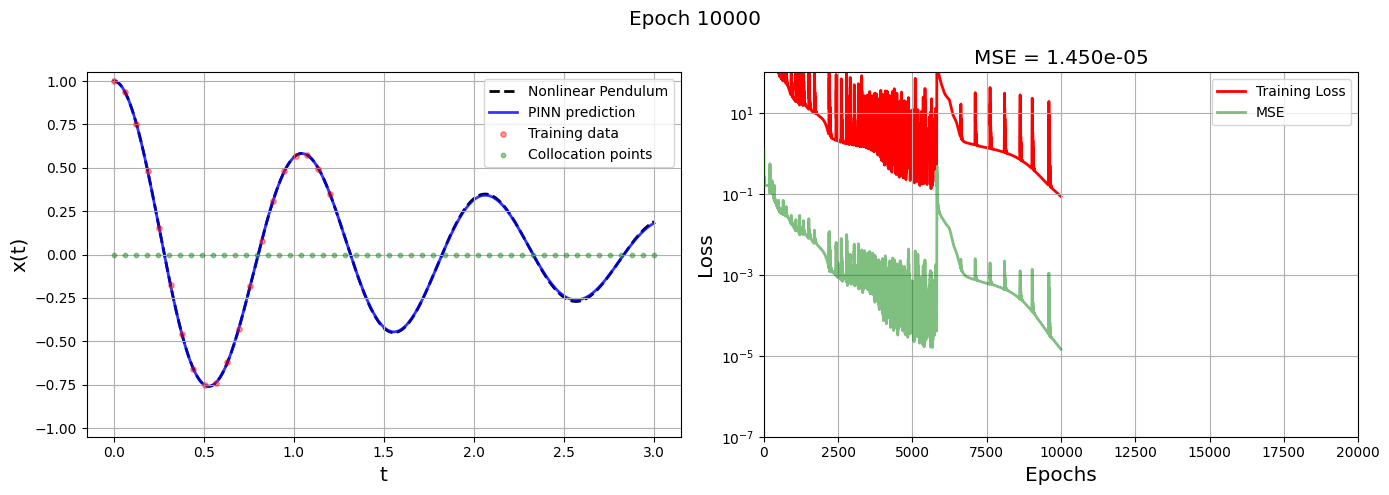

Epoch 10100: Error = 1.3163e-05, Omega = 6.279, NP Omega = 6.283, beta = 1.015, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10200: Error = 1.0203e-05, Omega = 6.281, NP Omega = 6.283, beta = 1.014, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10300: Error = 1.4477e-05, Omega = 6.277, NP Omega = 6.283, beta = 1.009, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10400: Error = 7.7707e-06, Omega = 6.281, NP Omega = 6.283, beta = 1.012, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10500: Error = 6.7188e-06, Omega = 6.281, NP Omega = 6.283, beta = 1.011, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10600: Error = 9.1969e-05, Omega = 6.277, NP Omega = 6.283, beta = 1.008, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10700: Error = 5.2743e-06, Omega = 6.282, NP Omega = 6.283, beta = 1.009, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10800: Error = 4.5811e-06, Omega = 6.282, NP Omega = 6.283, beta = 1.009, NP Beta = 1.000, Learning rate = 2.7249e-03
Epoch 10

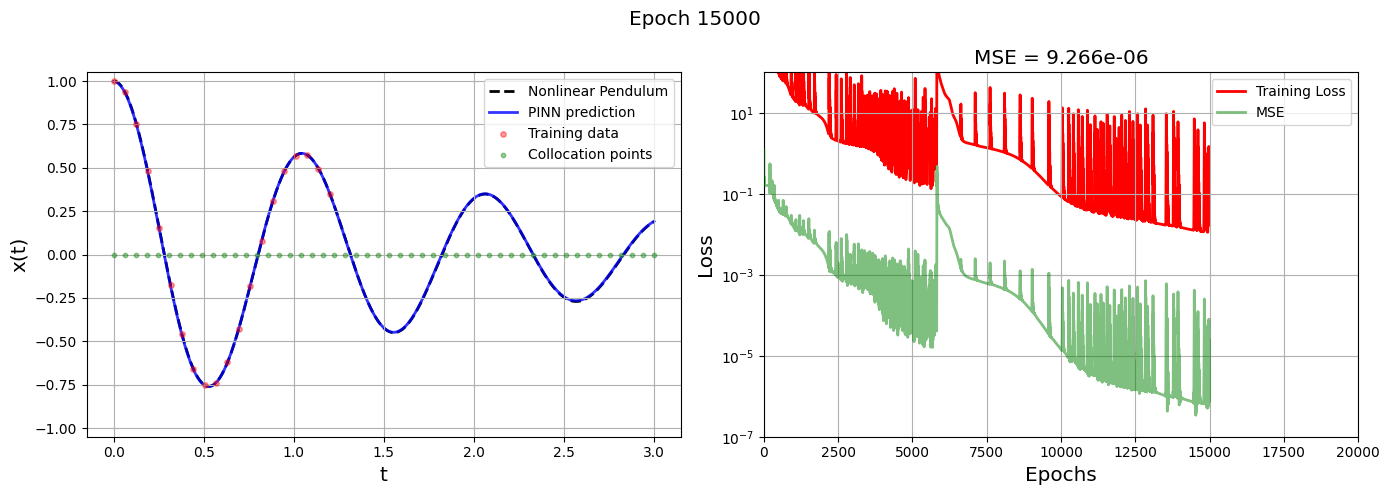

Epoch 15100: Error = 6.0893e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.6734e-03
Epoch 15200: Error = 5.8588e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.6734e-03
Epoch 15300: Error = 5.6433e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.6734e-03
Epoch 15400: Error = 1.1808e-05, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.6734e-03
Epoch 15500: Error = 9.7271e-06, Omega = 6.281, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.6734e-03
Epoch 15600: Error = 5.2705e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.4224e-03
Epoch 15700: Error = 5.1080e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.4224e-03
Epoch 15800: Error = 4.9199e-07, Omega = 6.282, NP Omega = 6.283, beta = 1.003, NP Beta = 1.000, Learning rate = 1.4224e-03
Epoch 15

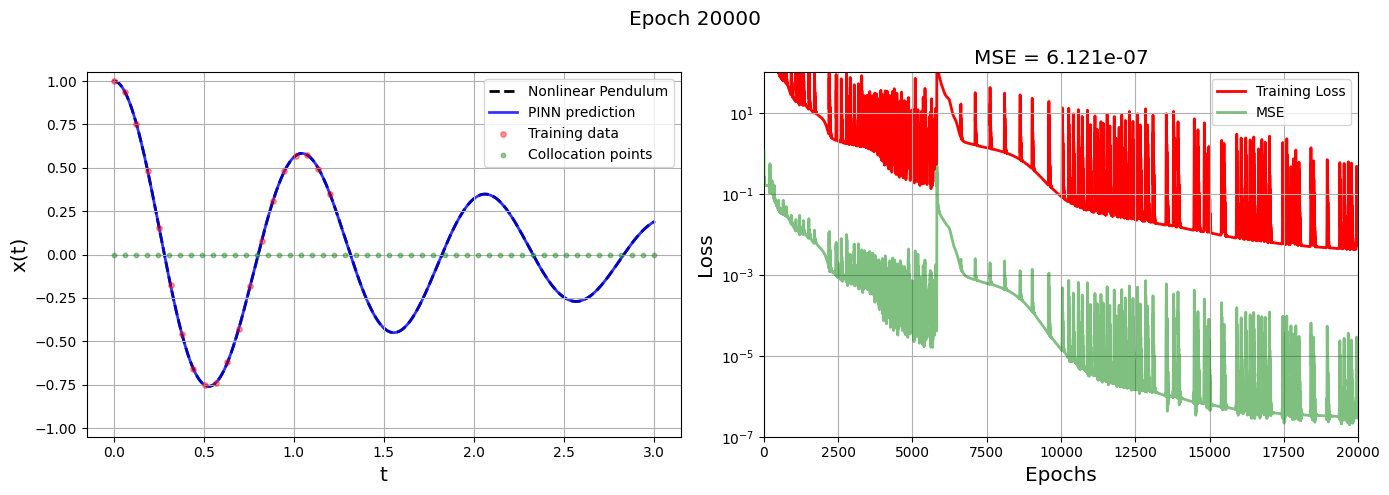

In [68]:
# PINN
PINN = FCN(1, 1, N_nodes, N_layers)

omega = torch.nn.Parameter(1*torch.ones(1, requires_grad=True))
beta  = torch.nn.Parameter(0*torch.ones(1, requires_grad=True))

# Uses the Adam optimizer
optimizer = torch.optim.Adam(list(PINN.parameters())+[omega]+[beta], lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=gamma, patience=patience, min_lr=1e-5, threshold=1e-4)

# Number of training steps
error_history           = []
training_loss_history   = []
validation_loss_history = []

omega_history = []
beta_history  = []
loss_val = torch.tensor(1.)

for i in range(epochs):
    # ===
    # Training
    # ===
    
    PINN.train()
    optimizer.zero_grad()
    
    # Compute data and derivative loss .........................
    u  = PINN(t_training)
    du = torch.autograd.grad(u, t_training, torch.ones_like(u), create_graph=True)[0]
    
    data_loss       = torch.mean((u  - x1_data)**2)
    derivative_loss = torch.mean((du - x2_data)**2)
    
    # Compute the ODE loss .........................
    
    z   = PINN(t_physics)
    dz  = torch.autograd.grad(z, t_physics, torch.ones_like(z), create_graph=True)[0]
    d2z = torch.autograd.grad(dz, t_physics, torch.ones_like(dz), create_graph=True)[0]
    
    training_params = (omega, beta)
    ode = d2z + sin(z)*omega**2 + beta*dz
    ode_loss = torch.mean(ode**2)
    
    # Compute total loss
    loss = w_data*data_loss + w_derivative*derivative_loss + w_ode*ode_loss
    
    p = PINN(t).detach()
    error = torch.mean((p - x1.view(-1,1))**2).item()
    
    # Backpropagate the loss and update weights
    loss.backward()
    optimizer.step()
    scheduler.step(error)
    
    # ===
    # Validation
    # ===
    PINN.eval()

    v   = PINN(t_validation)
    dv  = torch.autograd.grad(v, t_validation, torch.ones_like(v), create_graph=True)[0]
    d2v = torch.autograd.grad(dv, t_validation, torch.ones_like(dv), create_graph=True)[0]
    
    data_loss_val       = torch.mean((v - x1_val)**2)
    derivative_loss_val = torch.mean((dv - x2_val)**2)
    ode_loss_val        = torch.mean((d2v + v*omega**2)**2)

    loss_val = w_data*data_loss_val + w_derivative*derivative_loss_val + w_ode*ode_loss_val
    
    # ===
    # Saving training information
    # ===
    
    error_history.append(error)
    training_loss_history.append(loss.item())
    validation_loss_history.append(loss_val.item())
    
    omega_history.append(omega.item())
    beta_history.append(beta.item())
    
    # ===
    # Plotting
    # ===
    if (i % 100) == 0: 
        print(f"Epoch {i}: Error = {error:.4e}, Omega = {(omega.item()):.3f}, NP Omega = {w0:.3f}, beta = {beta.item():.3f}, NP Beta = {b:.3f}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}")
        if any([i==epochs-1, i%5_000==0, i==1000]):
            plot_result()
            plt.show()


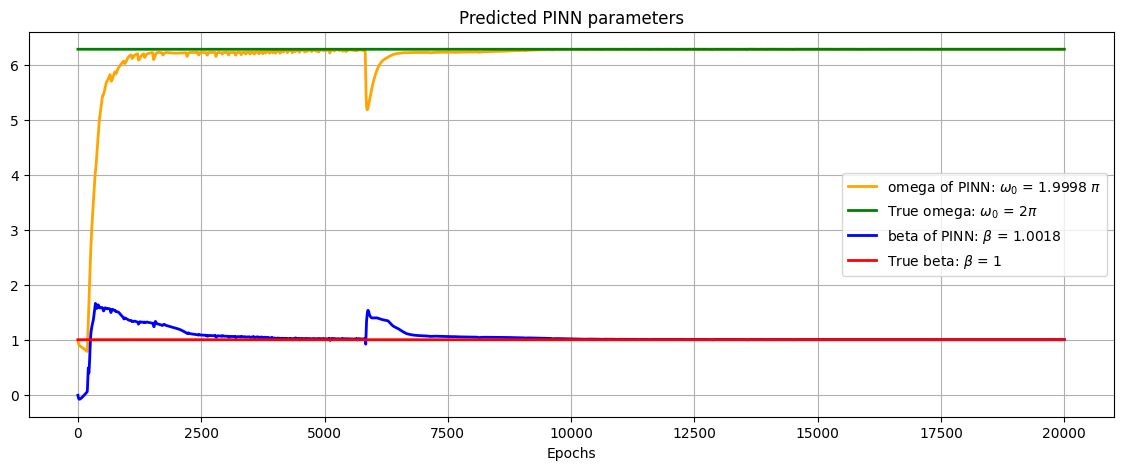

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))

r = omega.item()/np.pi

ax.plot(np.array(omega_history), label=f"omega of PINN: $\omega_0$ = {r:.4f} $\pi$", c="orange", lw=2)
ax.plot(w0*np.ones_like(omega_history), label=f"True omega: $\omega_0$ = $2 \pi$", c="green", lw=2)

ax.plot(np.array(beta_history), label=f"beta of PINN: $\\beta$ = {beta.item():.4f}", c="blue", lw=2)
ax.plot(b*np.ones_like(beta_history), label=f"True beta: $\\beta$ = 1", c="red", lw=2)

ax.grid()
ax.set_title("Predicted PINN parameters")
ax.set_xlabel("Epochs")
plt.legend()
plt.savefig("plots/parameter_comparison.png")
plt.show()

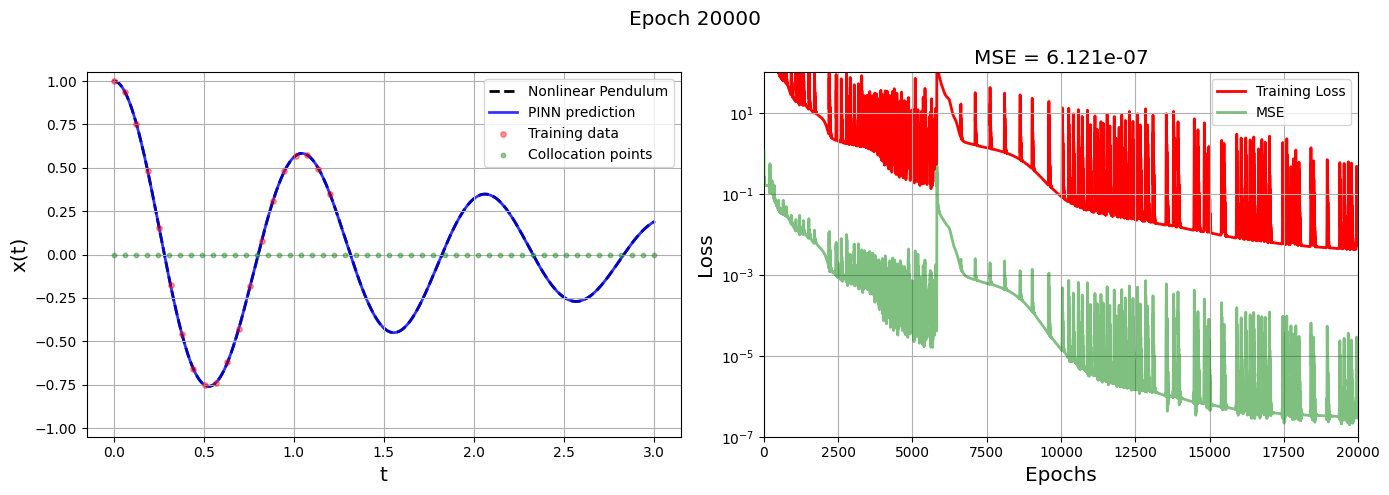

In [ ]:
plot_result()
plt.savefig("plots/Comaprison.png")